In [1]:
using SparseArrays, LinearAlgebra, Plots, LaTeXStrings
using KrylovKit: eigsolve
using Optim

theme(:lime)

In [2]:
hilbert_dim(k, n) = binomial(k + n - 1, n - 1)

function generate_basis(N, L)
    if L > 1
        basis = zeros(Int16, (hilbert_dim(N, L), L))
        j = 1
    
        for n in 0:N
            d = hilbert_dim(n, L - 1)
            basis[j:(j + d - 1), 1] .= (N - n)
            basis[j:(j + d - 1), 2:end] = generate_basis(n, L - 1)
            j += d
        end
        
    else
        basis = [N]
    end

    return basis
end

generate_basis (generic function with 1 method)

In [3]:
function hop(state, i, j)
    res_state = copy(state)
    res_state[i] += 1
    res_state[j] -= 1
    return res_state
end

# tags to label the basis states
tag(state) = sum(sqrt.(100 .* (1:length(state)) .+ 3) .* state)
unzip(arr) = map(x -> getfield.(arr, x), fieldnames(eltype(arr)))

function generate_kinetic(t, basis)
    D, L = size(basis)
    basis_tags = tag.(eachslice(basis, dims = 1)) # generate tags for each basis
    inds, basis_tags = sortperm(basis_tags), sort(basis_tags) # sorting tag-list for efficient searching

    H_kin = Dict{Tuple{Int64, Int64}, Float64}() # store sparse values; (index) -> val

    for v in 1:D # iterate through basis vectors
        state = basis[v, :] # get vth basis state 

        for j in 1:(L-1) # iterate through states (hopping) 
            
            i = j + 1 # Periodic BC

            if state[j] > 0 
                u = inds[searchsortedfirst(basis_tags, tag(hop(state, i, j)))]
                H_kin[(u, v)] = get(H_kin, (u, v), 0.) - t * ((state[i] + 1) * state[j]) ^ 0.5
            end
            
            if state[i] > 0
                u = inds[searchsortedfirst(basis_tags, tag(hop(state, j, i)))]
                H_kin[(u, v)] = get(H_kin, (u, v), 0.) - t * ((state[j] + 1) * state[i]) ^ 0.5
            end
        end
    end

    return sparse(unzip(keys(H_kin))..., collect(values(H_kin)), D, D)
end

generate_interaction(U, basis) = spdiagm(0.5 .* U .* sum(basis .* (basis .- 1), dims = 2) |> vec)

generate_number(basis) = spdiagm(sum(basis, dims = 2) |> vec)

generate_hamiltonian(t, U, basis) = generate_kinetic(t, basis) + generate_interaction(U, basis)

generate_hamiltonian (generic function with 1 method)

In [4]:
function a_lower(state, i)
    res_state = copy(state)
    res_state[i] -= 1
    return res_state
end

function a_raise(state, i)
    res_state = copy(state)
    res_state[i] += 1
    return res_state
end

function generate_a(basis, j)
    D, L = size(basis)
    basis_tags = tag.(eachslice(basis, dims = 1)) # generate tags for each basis
    inds, basis_tags = sortperm(basis_tags), sort(basis_tags) # sorting tag-list for efficient searching

    a_mat = Dict{Tuple{Int64, Int64}, Float64}() # store sparse values; (index) -> val

    for v in 1:D # iterate through basis vectors
        state = basis[v, :] # get vth basis state 

        u = inds[searchsortedfirst(basis_tags, tag(a_lower(state, j)))]

        if (u < length(basis_tags) + 1) && (sum(state) > 1)
            u = inds[u]
            a_mat[(u, v)] = get(a_mat, (u, v), 0.) + sqrt(state[j])
        end
    end

    return sparse(unzip(keys(a_mat))..., collect(values(a_mat)), D, D)
end

function generate_a_dag(basis, j)
    D, L = size(basis)
    basis_tags = tag.(eachslice(basis, dims = 1)) # generate tags for each basis
    inds, basis_tags = sortperm(basis_tags), sort(basis_tags) # sorting tag-list for efficient searching

    a_mat = Dict{Tuple{Int64, Int64}, Float64}() # store sparse values; (index) -> val

    for v in 1:D # iterate through basis vectors
        state = basis[v, :] # get vth basis state 

        u = searchsortedfirst(basis_tags, tag(a_raise(state, j)))

        if (u < length(basis_tags) + 1) # raised state may be outside our truncated basis state
            u = inds[u]
            a_mat[(u, v)] = get(a_mat, (u, v), 0.) + sqrt(state[j] + 1)
        end
    end

    return sparse(unzip(keys(a_mat))..., collect(values(a_mat)), D, D)
end

generate_a_dag (generic function with 1 method)

In [5]:
function generate_fock_basis(n_max, num_sites)
    basis = []
    for n in 1:n_max
        push!(basis, generate_basis(n, num_sites))  
    end

    return basis
end

function generate_fock_operator(param, op_func, basis)
    ops = []

    for n in 1:n_max
        push!(ops, op_func(param, basis[n]))
    end

    return blockdiag(ops...)
end

get_H(H, V_MF, t, psi) = H + (t * (-psi * V_MF + 2 * psi^2 * I))

function get_order_parameter(H, V_MF, t)
    E_gs(psi) = eigsolve(get_H(H, V_MF, t, psi[1]), 1, :SR)[1][1] |> real
    return Optim.minimizer(optimize(E_gs, zeros(1)))[1]
end

get_order_parameter (generic function with 1 method)

In [12]:
n_max, num_sites = 15, 4

basis = generate_fock_basis(n_max, num_sites);
Hk = generate_fock_operator(1, generate_kinetic, basis);
Hv = generate_fock_operator(1, generate_interaction, basis);

basis = vcat(basis...)
Hn = generate_number(basis)

_, L = size(basis)
V_MF = generate_a(basis, 1) + generate_a_dag(basis, 1) + generate_a(basis, L) + generate_a_dag(basis, L);

In [13]:
num_points = 75
t = range(start = 0, stop = 0.2, length = num_points)
mu = range(start = -0.2, stop = 1.2, length = num_points)

order_param = zeros((num_points, num_points))

for k1 in 1:num_points, k2 in 1:num_points
    order_param[k2, k1] = abs(get_order_parameter((t[k1] * Hk) + Hv - (mu[k2] * Hn), V_MF, t[k1]))
end

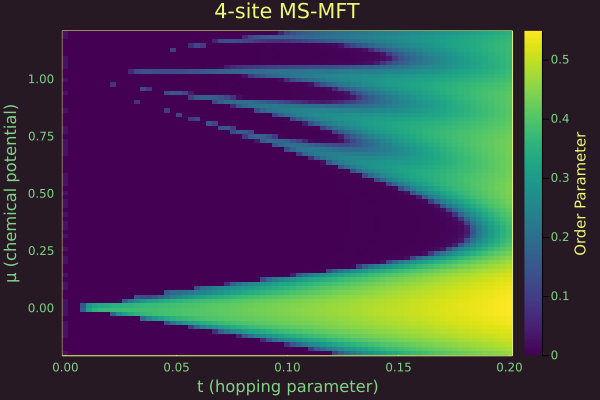

In [14]:
p1 = heatmap(t, mu, order_param)
plot!(
    ylabel = "μ (chemical potential)",
    xlabel = "t (hopping parameter)",
    framestyle = :box, 
    title = "$(num_sites)-site MS-MFT",  
    colorbar_title = "Order Parameter")